In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from IPython.display import HTML
import scipy.stats as stats
from scipy import sparse
from time import time

## Compilation of Numerical Methods for Solving the Advection Equation
This notebook contains a standardised set of solutions using various methods. It currently contains:
* Forward Euler - FTFS
* Forward Euler - FTCS
* Backward Euler
* Leapfrog
* Lax-Wendroff

In each graph the blue line represents the approximation produced by the method and the orange dashed line represents the analytical solution.

In [2]:
def graph(M, T, dx, dt, c, js, ics, method):
    ### Produce a graph of the approximation
    ## Find sizes for matrices
    Ms = int(M/dx)
    Ts = int(T/dt)+1
    
    ## Initial matrix
    u = np.zeros((Ms,Ts))
    u[:,0]=ics(Ms)
    
    ## Find particle density for each timestep
    for t in range(Ts):
        for x in range(Ms):
            u[x,t]=u[int(np.round(((x*dx)-(c*t*dt))/dx, 0))%Ms,0]
            
    ## Approximation
    ua = method(Ms, Ts, c, dt, dx, ics)

        
    ## Plot graphs
    maxi = np.max(ua[:,0])*1.1
    fig, axs = plt.subplots(1, 4, figsize=(13,3))
    fig.tight_layout()
    fig.subplots_adjust(top=0.8)
    for ax, j in zip(axs, js(Ts)):
        ax.set_title("T="+str(j*dt))
        ax.set(xlim=(0, M), ylim=(-maxi, maxi))
        ax.plot(np.arange(0,M,M/Ms), ua[:,j])
        ax.plot(np.arange(0,M,M/Ms), u[:,j], ':')

In [3]:
def js1(Ts):
    ### Spots to take graphs at
    return [0,int(np.round(Ts/10, 0)),int(np.round(Ts/2, 0)),int(np.round(Ts-1, 0))]

def tophat(Ms):
    ### Initial conditions
    return [1 if i>int(3*Ms/8) and i<int(5*Ms/8) else 0 for i in range(Ms)]

def normcurve(Ms):
    ### Initial conditions
    mu = int(Ms/2) # Middle value for the normal curve
    sig = int(Ms/20) # Variance for normal curve
    xa=np.linspace(0,Ms-1,Ms)
    return stats.norm.pdf(xa, mu, sig)/max(stats.norm.pdf(xa, mu, sig)) # Normal curve centred at mu with variance sig

### Forward Euler - FTFS
Upwinding in space, forward in time. Since $a>0$,
$$
U_{j}^{n+1}=U_{j}^{n}-\frac{ak}{h}\left(U_{j}^{n}-U_{j-1}^{n}\right)
$$

Let $c=\frac{ak}{h}$. Now we find the linear system (I stick to a 4x4 for symplicity's sake) corresponding to the above formula,

$$
\vec{u}^{n+1}=A\vec{u}^n
$$

With the matrix,
$$ A=
\begin{pmatrix}
1-c&0&0&c\\
c&1-c&0&0\\
0&c&1-c&0\\
0&0&c&1-c
\end{pmatrix}
$$

In [4]:
def ftfsMethod(Ms, Ts, c, dt, dx, ics):
    ### Forward Euler - ftfs
    ## Initial matrix
    ua = np.zeros((Ms,Ts))
    ua[:,0]=ics(Ms)

    ## Generate the sparse matrix, A
    a = c*dt/dx
    A = sparse.dok_matrix((Ms,Ms))
    for i in range(Ms):
        A[i,i-1]=a
        A[i,i]=1-a
    A=A.tocsc()
    
    ## Find particle density for each timestep
    for n in range(Ts-1):
        ua[:,n+1]=A.dot(ua[:,n])
        
    return ua

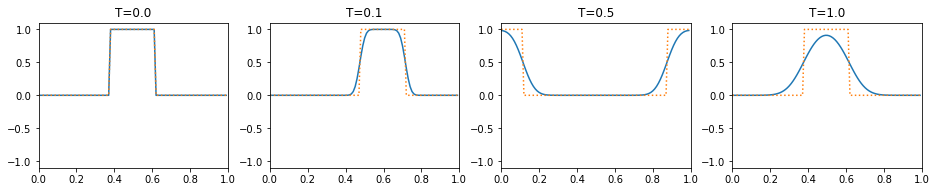

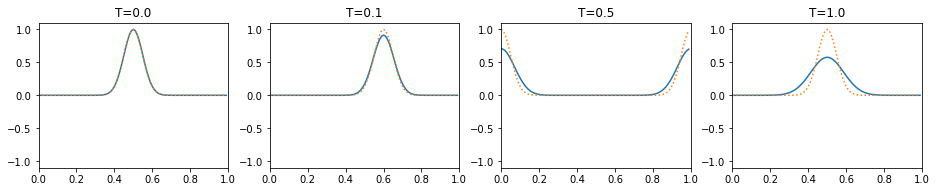

In [5]:
graph(1, 1,  0.01,  0.005,  1, js1, tophat, ftfsMethod)
graph(1, 1,  0.01,  0.005,  1, js1, normcurve, ftfsMethod)

### Forward Euler - FTCS
Centered in space, forward in time.
$$
U_{j}^{n+1}=U_{j}^{n}-\frac{ak}{2h}\left(U_{j+1}^{n}-U_{j-1}^{n}\right)
$$

Let $c=\frac{ak}{h}$. Now we find the linear system (I stick to a 4x4 for symplicity's sake) corresponding to the above formula,

$$
\vec{u}^{n+1}=A\vec{u}^n
$$

With the matrix,
$$ A=
\begin{pmatrix}
1&-c/2&0&c/2\\
c/2&1&-c/2&0\\
0&c/2&1&-c/2\\
-c/2&0&c/2&1
\end{pmatrix}
$$

In [6]:
def ftcsMethod(Ms, Ts, c, dt, dx, ics):
    ### Forward Euler - ftfs
    ## Initial matrix
    ua = np.zeros((Ms,Ts))
    ua[:,0]=ics(Ms)

    ## Generate the sparse matrix, A
    a = c*dt/dx
    A = sparse.dok_matrix((Ms,Ms))
    for i in range(Ms):
        A[i-1,i]=-a/2
        A[i,i]=1
        A[i,i-1]=a/2
    A=A.tocsc()
    
    ## Find particle density for each timestep
    for n in range(Ts-1):
        ua[:,n+1]=A.dot(ua[:,n])
        
    return ua

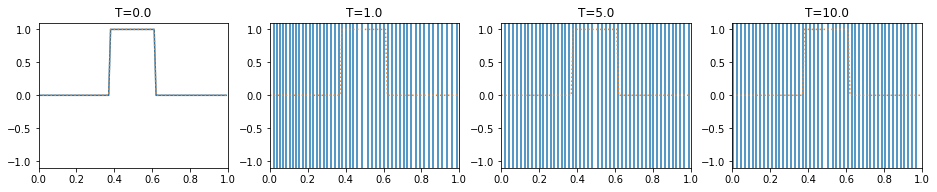

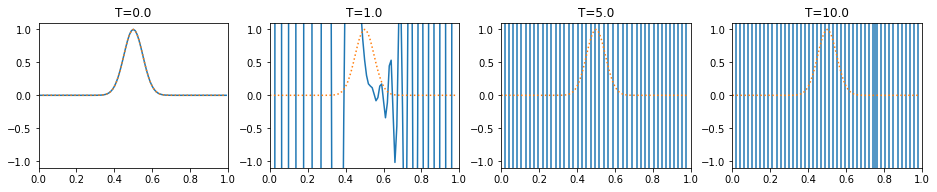

In [7]:
graph(1, 10,  0.01,  0.005,  1, js1, tophat, ftcsMethod)
graph(1, 10,  0.01,  0.005,  1, js1, normcurve, ftcsMethod)

### Backward Euler
Centered in space and backward in time.
$$
U_{j}^{n+1}+\frac{ak}{2h}\left(U_{j+1}^{n+1}-U_{j-1}^{n+1}\right)=U_{j}^n
$$

Let $c=\frac{ak}{h}$. Now we find the linear system (I stick to a 4x4 for symplicity's sake) corresponding to the above formula,

$$
A\vec{u}^{n+1}=\vec{u}^n
$$

With the matrix,
$$ A=
\begin{pmatrix}
1&c/2&0&-c/2\\
-c/2&1&c/2&0\\
0&-c/2&1&c/2\\
c/2&0&-c/2&1
\end{pmatrix}
$$

In [8]:
def beMethod(Ms, Ts, c, dt, dx, ics):
    ### Backward Euler
    ## Initial matrix
    ua = np.zeros((Ms,Ts))
    ua[:,0]=ics(Ms)

    ## Generate the sparse matrix, A
    a = c*dt/(2*dx)
    A = sparse.dok_matrix((Ms,Ms))
    for i in range(Ms):
        A[i,i-1]=-a
        A[i,i]=1
        A[i-1,i]=a
    A=A.tocsc()

    ## Find particle density for each timestep
    for n in range(Ts-1):
        ua[:,n+1]=sparse.linalg.spsolve(A, ua[:,n])
        
    return ua

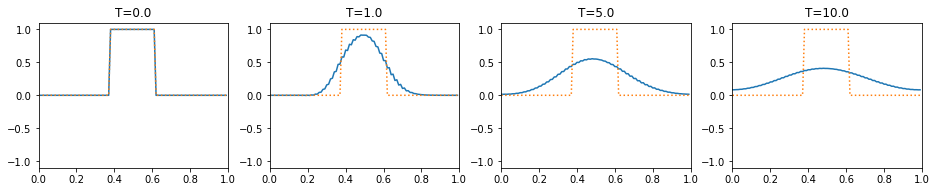

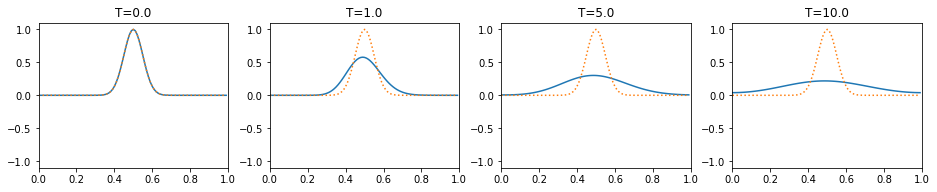

In [9]:
graph(1, 10,  0.01,  0.005,  1, js1, tophat, beMethod)
graph(1, 10,  0.01,  0.005,  1, js1, normcurve, beMethod)

### Leapfrog
$$
U_{j}^{n+1}=U_{j}^{n-1}-\frac{ak}{h}\left(U_{j+1}^{n}-U_{j-1}^{n}\right)
$$

Let $c=\frac{ak}{h}$. Now we find the linear system (I stick to a 4x4 for symplicity's sake) corresponding to the above formula,

$$
\vec{u}^{n+1}=\vec{u}^{n-1}-A\vec{u}^n
$$

With the matrix,
$$ A=
\begin{pmatrix}
0&-c&0&c\\
c&0&-c&0\\
0&c&0&-c\\
-c&0&c&0
\end{pmatrix}
$$

In [10]:
def lfMethod(Ms, Ts, c, dt, dx, ics):
    ### Leapfrog
    ## Initial matrix
    ua = np.zeros((Ms,Ts))
    ua[:,0]=ics(Ms)
    a=c*dt/2/dx
    Ap = sparse.dok_matrix((Ms, Ms))
    Am = sparse.dok_matrix((Ms, Ms))
    for i in range(Ms):
        Ap[i,i]=1
        Am[i,i]=1
        Ap[i-1,i]=a
        Am[i-1,i]=-a
        Ap[i,i-1]=-a
        Am[i,i-1]=a
    Ap = sparse.linalg.inv(Ap.tocsc())
    Am = Am.tocsc()
    ua[:,1]=Ap.dot(Am.dot(ua[:,0]))
    
    ## Generate the sparse matrix, A
    a = c*dt/dx
    A = sparse.dok_matrix((Ms,Ms))
    for i in range(Ms):
        A[i-1,i]=a
        A[i,i-1]=-a
    A=A.tocsc()

    ## Find particle density for each timestep
    for n in range(1, Ts-1):
        ua[:,n+1]=ua[:,n-1]-A.dot(ua[:,n])
        
    return ua

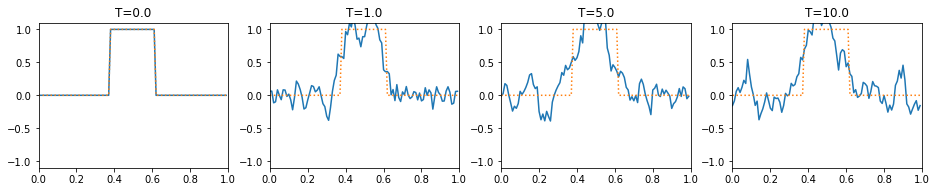

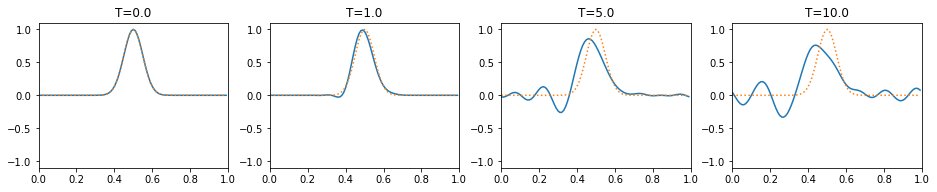

In [11]:
graph(1, 10,  0.01,  0.005,  1, js1, tophat, lfMethod)
graph(1, 10,  0.01,  0.005,  1, js1, normcurve, lfMethod)

### Lax-Wendroff
$$
U_{j}^{n+1}=U_{j}^n-\frac{ak}{2h}(U^n_{j+1}-U^n_{j-1})+\frac{a^2k^2}{2h^2}(U^n_{j-1}-2U_{j}^n+U^n_{j+1})
$$

Let $c=\frac{ak}{h}$. Now we find the linear system (I stick to a 4x4 for symplicity's sake) corresponding to the above formula,

$$
\vec{u}^{n+1}=A\vec{u}^n
$$

With the matrix,
$$ A=
\begin{pmatrix}
1-c^2&c(c-1)/2&0&c(1+c)/2\\
c(1+c)/2&1-c^2&c(c-1)/2&0\\
0&c(1+c)/2&1-c^2&c(c-1)/2\\
c(c-1)/2&0&c(1+c)/2&1-c^2\\
\end{pmatrix}
$$

In [12]:
def lwMethod(Ms, Ts, c, dt, dx, ics):
    ### Lax-Wendroff
    ## Initial matrix
    ua = np.zeros((Ms,Ts))
    ua[:,0]=ics(Ms)
    
    ## Generate the sparse matrix, A
    a = c*dt/dx
    A = sparse.dok_matrix((Ms,Ms))
    for i in range(Ms):
        A[i,i-1]=(a+a**2)/2
        A[i,i]  =1-a**2
        A[i-1,i]=(a**2-a)/2
    A=A.tocsr()

    ## Multiply A*u^n
    for n in range(Ts-1):
        ua[:,n+1]=A.dot(ua[:,n])
        
    return ua

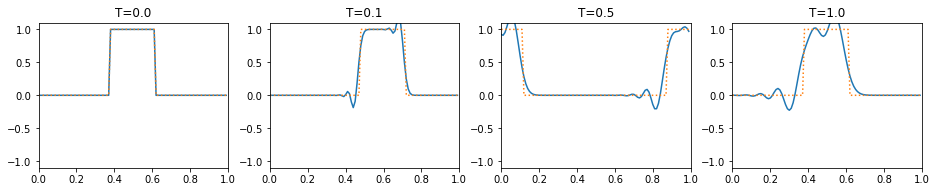

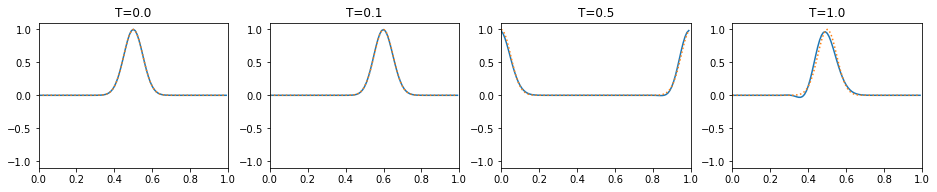

In [13]:
graph(1, 1,  0.01,  0.005,  1, js1, tophat, lwMethod)
graph(1, 1,  0.01,  0.005,  1, js1, normcurve, lwMethod)